In [1]:
# Specify device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import json
import os
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
from termcolor import colored
from _paths import nomeroff_net_dir
from nomeroff_net import pipeline
from nomeroff_net.tools import unzip
from nomeroff_net.tools.image_processing import convert_cv_zones_rgb_to_bgr

In [14]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

In [19]:
class MaskDatasetChecker:
    def __init__(self):
        self.dataset = {}
        self.detector = pipeline("number_plate_detection_and_reading", image_loader="opencv")
        
    def load_dataset(self, json_path):
        dataset = {}
        print("Loading dataset...")
        with open(json_path) as json_file:
            data = json.load(json_file)
            for p in tqdm.tqdm(data['_via_img_metadata']):
                item = data['_via_img_metadata'][p]
                file_name = item["filename"]
                bboxes = []
                for region in item['regions']:
                    x1 = min(region['shape_attributes']['all_points_x'])
                    x2 = max(region['shape_attributes']['all_points_x'])
                    y1 = min(region['shape_attributes']['all_points_y'])
                    y2 = max(region['shape_attributes']['all_points_y'])
                    bboxes.append({
                        'x1': x1, 
                        'x2': x2, 
                        'y1': y1, 
                        'y2': y2, 
                        'xs': region['shape_attributes']['all_points_x'],
                        'ys': region['shape_attributes']['all_points_y'],
                        'region_name': region['region_attributes']["region_name"].strip(),
                        'numberplate': region['region_attributes']["np"].strip(),
                    })
                dataset[file_name] = bboxes
        self.dataset = dataset
    
    def predict(self, image_paths, use_target_box_from_dataset=1, use_option_from_dataset=1, debug=1):
        predicted = {}
        print("Predicting...")
        
        counter = Counter()
        for img_path in tqdm.tqdm(image_paths):
            result = self.detector([
                img_path
            ])
            
            (images, images_bboxs, 
             images_points, images_zones, region_ids, 
             region_names, count_lines, 
             confidences, texts) = unzip(result)

            # append to predicted
            predicted[os.path.basename(img_path)] = []
            for numberplate, points, region_name in zip(texts[0], images_points[0], region_names[0]):
                print(numberplate, points, region_name)
                predicted[os.path.basename(img_path)].append({
                    'x1': points[0], 
                    'x2': points[2], 
                    'y1': points[1], 
                    'y2': points[3], 
                    'region_name': region_name.strip(),
                    'numberplate': numberplate.strip(),
                })

            # dispaly debug info
            dataset_info = predicted[os.path.basename(img_path)]
            if debug:
                trues = [np["numberplate"] for np in dataset_info]
                plt.imshow(images[0])
                plt.show()
                print(img_path, colored(trues, "blue"))
                for zone, numberplate, points, region_name in zip(convert_cv_zones_rgb_to_bgr(images_zones[0]), 
                                                                  texts[0], 
                                                                  images_points[0], 
                                                                  region_names[0]):
                    color = "yellow"
                    if numberplate in trues:
                        counter["good"] += 1
                        color = "green"
                    else:
                        counter["bad"] += 1

                    plt.imshow(zone)
                    plt.show()
                    print(colored(json.dumps({
                        'region_name': region_name.strip(),
                        'numberplate': numberplate.strip(),
                    }), color))

        
        if debug:             
            print(colored(str(counter), 'blue'))
        return predicted
    
    def compare(self, 
                photo_dir = os.path.join(nomeroff_net_dir, 
                                         './data/dataset/Detector/autoria_numberplate_dataset_example/train'),
                json_path = os.path.join(nomeroff_net_dir, 
                                         './data/dataset/Detector/autoria_numberplate_dataset_example/train/via_region_data.json'),
                use_target_box_from_dataset=1, 
                use_option_from_dataset=1,
                iou_less_than = 0.9,
                ocr_acc_less_than = 0.7,
                option_acc_less_than = 0.7,
                mask_acc_less_than = 0.7):
        """
        TODO: add more comparisons
        """         
        self.load_dataset(json_path)
        image_paths = [os.path.join(photo_dir, image_name) for image_name in self.dataset]
        self.predict(image_paths,
                     use_option_from_dataset=use_option_from_dataset,
                     use_target_box_from_dataset=use_target_box_from_dataset)

In [20]:
maskDatasetChecker = MaskDatasetChecker()

YOLOv5 🚀 v6.1-2-g4bab565 torch 1.9.0+cu102 CPU

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients


Loading weights from checkpoint (/mnt/data/var/www/nomeroff-net/tools/py/../../nomeroff_net/tools/../../data/./models/np_points_craft/craft_mlt/craft_mlt_25k_2020-02-16.pth)
Loading weights of refiner from checkpoint (/mnt/data/var/www/nomeroff-net/tools/py/../../nomeroff_net/tools/../../data/./models/np_points_craft/craft_refiner/craft_refiner_CTW1500_2020-02-16.pth)


In [21]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

  0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset...
Predicting...


/mnt/data/var/www/nomeroff-net/tools/py/../../nomeroff_net/nnmodels/numberplate_options_model.py:111: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x1 = functional.softmax(self.fc3_reg(x1))
/mnt/data/var/www/nomeroff-net/tools/py/../../nomeroff_net/nnmodels/numberplate_options_model.py:120: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x2 = functional.softmax(self.fc3_line(x2))


NEBV043 [[295.48188453150317, 907.8270514433996], [251.81414011871092, 839.0907770812951], [488.3322534766215, 688.8322363895612], [532.0, 757.5685128475304]] eu


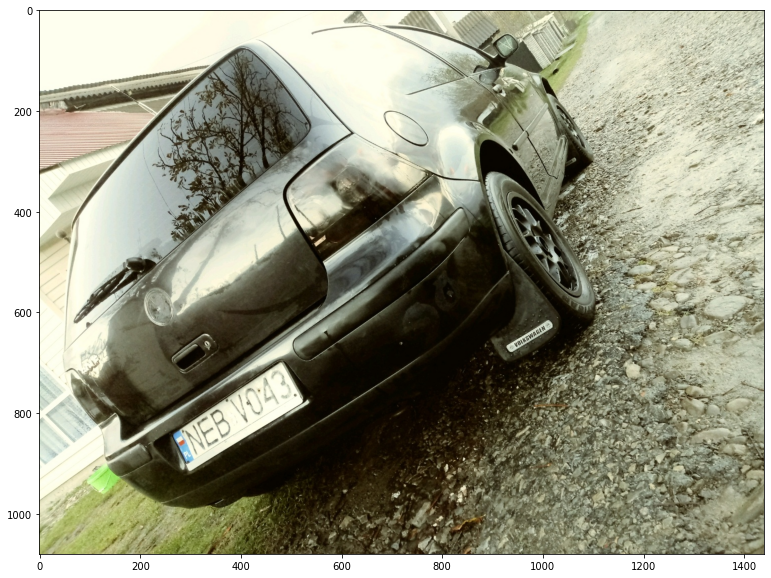

/mnt/data/var/www/nomeroff-net/tools/py/../.././data/dataset/Detector/yolov5/autoria_numberplate_dataset_example/train/250031471orig.jpeg ['NEBV043']


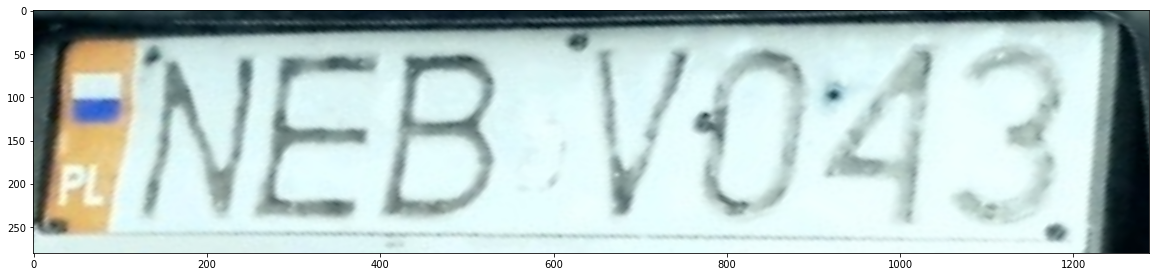

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

{"region_name": "eu", "numberplate": "NEBV043"}
Counter({'good': 1})


In [22]:
num = 12
maskDatasetChecker.compare(
    photo_dir = os.path.join(nomeroff_net_dir, 
                             './data/dataset/Detector/autoria_numberplate_dataset_example/train'),
    json_path = os.path.join(nomeroff_net_dir, 
                             './data/dataset/Detector/autoria_numberplate_dataset_example/train/via_region_data.json'),
    use_target_box_from_dataset=1, 
    use_option_from_dataset=1
)